### Imports

In [25]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob

### Load Data:

In [26]:


parquet_files = glob.glob("data/silver_features/*.parquet")
df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)

### Data Preprocessing:

In [16]:
df["y_final"] = df["y_final"].astype(int)
df["had_trade"] = df["had_trade"].astype(int)

df["ret_1"] = df["ret_1"].fillna(0.0)
df["vol_7"] = df["vol_7"].fillna(0.0)

df["log_volume"] = np.log1p(df["volume"].astype(float))
df["log_open_interest"] = np.log1p(df["open_interest"].astype(float))
df["log_time_to_close"] = np.log1p(df["time_to_close_sec"].clip(lower=0).astype(float))


# Experiment 1

Feature definition and train/test split:

In [17]:

feature_cols = [
    "p_mkt", "spread", "log_volume", "log_open_interest",
    "log_time_to_close", "ret_1", "vol_7", "had_trade"
]

X = df[feature_cols].astype(float)
y = df["y_final"].values
groups = df["condition_id"].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]


Model training and evaluation:

In [27]:


p_base = np.clip(X_test["p_mkt"].values, 1e-6, 1-1e-6)

model = LogisticRegression(max_iter=2000, class_weight="balanced")
model.fit(X_train, y_train)

p_model = np.clip(model.predict_proba(X_test)[:, 1], 1e-6, 1-1e-6)

print("Test markets:", len(np.unique(groups[test_idx])))
print("Baseline logloss:", log_loss(y_test, p_base))
print("Model    logloss:", log_loss(y_test, p_model))
print("Baseline brier  :", brier_score_loss(y_test, p_base))
print("Model    brier  :", brier_score_loss(y_test, p_model))


Test markets: 52
Baseline logloss: 1.827648881051328
Model    logloss: 0.6072170695090967
Baseline brier  : 0.3920733868614249
Model    brier  : 0.20691192637545677


Model analysis and evaluation:

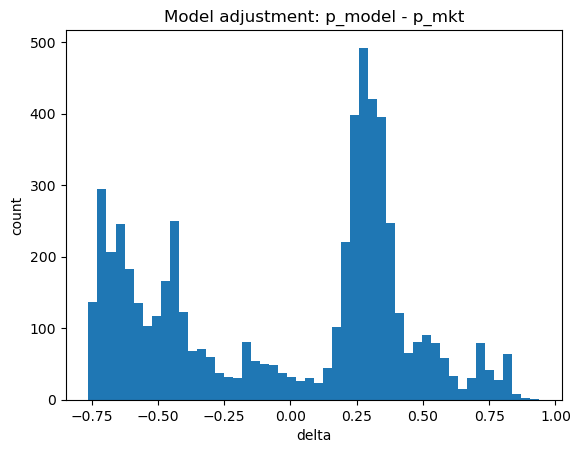

spread              -3.096619
vol_7               -2.592169
had_trade            1.708843
p_mkt                1.424862
ret_1               -0.680107
log_time_to_close   -0.115658
log_volume          -0.015434
log_open_interest   -0.015434
dtype: float64


In [28]:

plt.figure()
plt.hist(p_model - p_base, bins=50)
plt.title("Model adjustment: p_model - p_mkt")
plt.xlabel("delta")
plt.ylabel("count")
plt.show()

coefs = pd.Series(model.coef_[0], index=feature_cols).sort_values(key=abs, ascending=False)
print(coefs)

# Experiment 2: training with snapshots

Using 1 snapshot per market. For each market, we select the snapshot closest to 7 days before close (but not closer than 7 days).
This ensures we're evaluating at a consistent time horizon and avoiding snapshots too close to market resolution.

In [32]:
# Create snapshot dataset: 1 snapshot per market
DAYS_BEFORE_CLOSE = 7
SECONDS_BEFORE_CLOSE = DAYS_BEFORE_CLOSE * 24 * 60 * 60

# Filter to snapshots >= 7 days before close
df_filtered = df[df["time_to_close_sec"] >= SECONDS_BEFORE_CLOSE].copy()

# For each market, select the snapshot closest to 7 days (minimum time_to_close_sec)
df_one_per_market = df_filtered.loc[
    df_filtered.groupby("condition_id")["time_to_close_sec"].idxmin()
].copy()

# Show time-to-close distribution for selected snapshots
print(f"Total markets: {len(df_one_per_market)}")
print(f"\nTime to close distribution (seconds):")
print(df_one_per_market["time_to_close_sec"].describe())
print(f"\nTime to close distribution (days):")
print((df_one_per_market["time_to_close_sec"] / (24 * 60 * 60)).describe())

Total markets: 256

Time to close distribution (seconds):
count    2.560000e+02
mean     2.238959e+06
std      2.224600e+06
min      6.192000e+05
25%      6.228000e+05
50%      6.660000e+05
75%      3.906000e+06
max      7.534800e+06
Name: time_to_close_sec, dtype: float64

Time to close distribution (days):
count    256.000000
mean      25.913873
std       25.747689
min        7.166667
25%        7.208333
50%        7.708333
75%       45.208333
max       87.208333
Name: time_to_close_sec, dtype: float64


Data Exploration:

In [ ]:

tmp = df_one_per_market.copy()
print(tmp.groupby("y_final")["p_mkt"].mean())

## model training and evaluation:

In [ ]:
# Use the snapshots created in the previous cell

feature_cols = [
    "p_mkt", "spread", "log_volume", "log_open_interest",
    "log_time_to_close", "ret_1", "vol_7", "had_trade"
]

X_snapshots = df_one_per_market[feature_cols].astype(float)
y_snapshots = df_one_per_market["y_final"].values
groups_snapshots = df_one_per_market["condition_id"].values

# Split by market (same random_state for consistency)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx_snapshots, test_idx_snapshots = next(gss.split(X_snapshots, y_snapshots, groups=groups_snapshots))

X_train_snapshots = X_snapshots.iloc[train_idx_snapshots]
X_test_snapshots = X_snapshots.iloc[test_idx_snapshots]
y_train_snapshots = y_snapshots[train_idx_snapshots]
y_test_snapshots = y_snapshots[test_idx_snapshots]

print("=" * 60)
print("TRAINING MODEL ON SNAPSHOTS (1 per market)")
print("=" * 60)
print(f"Training on {len(X_train_snapshots)} snapshots from {len(np.unique(groups_snapshots[train_idx_snapshots]))} markets")
print(f"Testing on {len(X_test_snapshots)} snapshots from {len(np.unique(groups_snapshots[test_idx_snapshots]))} markets")

# Baseline predictions
p_base_snapshots = np.clip(X_test_snapshots["p_mkt"].values, 1e-6, 1-1e-6)

# Train model
model_snapshots = LogisticRegression(max_iter=2000, class_weight="balanced")
print("\nTraining model...")
model_snapshots.fit(X_train_snapshots, y_train_snapshots)
print("Training complete!")

# Model predictions
p_model_snapshots = np.clip(model_snapshots.predict_proba(X_test_snapshots)[:, 1], 1e-6, 1-1e-6)

# Evaluate
print("\n" + "=" * 60)
print("EVALUATION RESULTS (SNAPSHOTS)")
print("=" * 60)
print(f"Test markets: {len(np.unique(groups_snapshots[test_idx_snapshots]))}")
print(f"Baseline logloss: {log_loss(y_test_snapshots, p_base_snapshots):.6f}")
print(f"Model    logloss: {log_loss(y_test_snapshots, p_model_snapshots):.6f}")
print(f"Baseline brier  : {brier_score_loss(y_test_snapshots, p_base_snapshots):.6f}")
print(f"Model    brier  : {brier_score_loss(y_test_snapshots, p_model_snapshots):.6f}")
print(f"\nImprovement:")
print(f"  Logloss: {log_loss(y_test_snapshots, p_base_snapshots) - log_loss(y_test_snapshots, p_model_snapshots):.6f} ({((log_loss(y_test_snapshots, p_base_snapshots) - log_loss(y_test_snapshots, p_model_snapshots)) / log_loss(y_test_snapshots, p_base_snapshots) * 100):.1f}% reduction)")
print(f"  Brier:   {brier_score_loss(y_test_snapshots, p_base_snapshots) - brier_score_loss(y_test_snapshots, p_model_snapshots):.6f} ({((brier_score_loss(y_test_snapshots, p_base_snapshots) - brier_score_loss(y_test_snapshots, p_model_snapshots)) / brier_score_loss(y_test_snapshots, p_base_snapshots) * 100):.1f}% reduction)")


TRAINING MODEL ON SNAPSHOTS (1 per market)
Training on 204 snapshots from 204 markets
Testing on 52 snapshots from 52 markets

Training model...
Training complete!

EVALUATION RESULTS (SNAPSHOTS)
Test markets: 52
Baseline logloss: 1.334797
Model    logloss: 0.504359
Baseline brier  : 0.270711
Model    brier  : 0.174698

Improvement:
  Logloss: 0.830437 (62.2% reduction)
  Brier:   0.096013 (35.5% reduction)


Model coefficients (snapshots):
vol_7               -1.944855
p_mkt                1.616488
spread              -1.317415
log_time_to_close   -0.952003
ret_1               -0.565228
log_volume           0.071009
log_open_interest    0.071009
had_trade            0.000438
dtype: float64


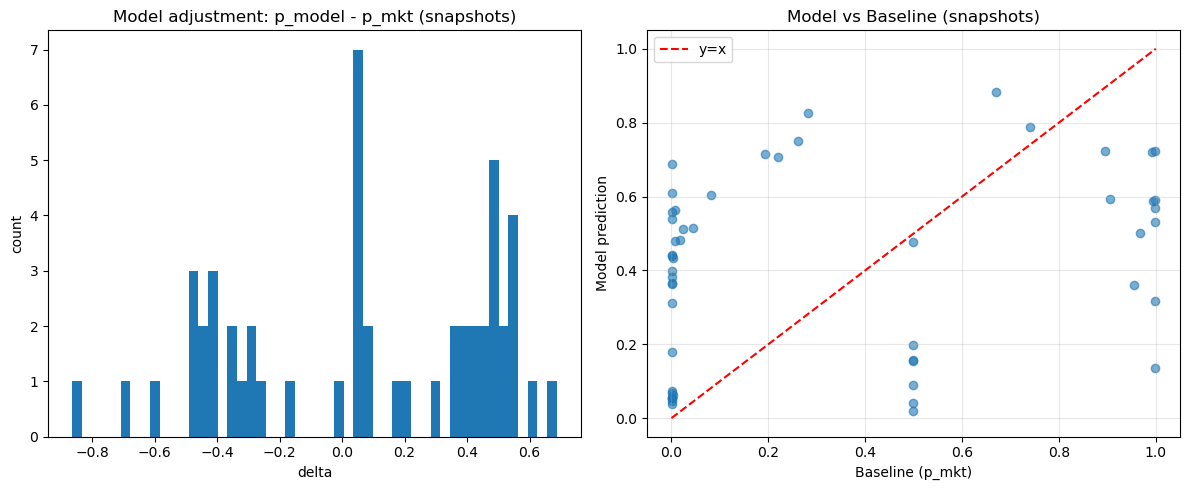

In [33]:
# Compare coefficients and model adjustments
coefs_snapshots = pd.Series(model_snapshots.coef_[0], index=feature_cols).sort_values(key=abs, ascending=False)

print("Model coefficients (snapshots):")
print(coefs_snapshots)

# Plot model adjustments
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(p_model_snapshots - p_base_snapshots, bins=50)
plt.title("Model adjustment: p_model - p_mkt (snapshots)")
plt.xlabel("delta")
plt.ylabel("count")

plt.subplot(1, 2, 2)
plt.scatter(p_base_snapshots, p_model_snapshots, alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', label="y=x")
plt.xlabel("Baseline (p_mkt)")
plt.ylabel("Model prediction")
plt.title("Model vs Baseline (snapshots)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


y_final
0    0.383068
1    0.547562
Name: p_mkt, dtype: float64


In [24]:
cols_no_time = [c for c in feature_cols if c != "log_time_to_close"]

m = LogisticRegression(max_iter=2000, class_weight="balanced")
m.fit(X_train_snapshots[cols_no_time], y_train_snapshots)

p = np.clip(m.predict_proba(X_test_snapshots[cols_no_time])[:, 1], 1e-6, 1-1e-6)
print("No-time logloss:", log_loss(y_test_snapshots, p))



No-time logloss: 0.4948315541227087
